In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
%config InlineBackend.figure_format='retina'

# How to Finally Ditch Spreadsheets in favour of Notebooks

Recently, it is becoming more and more common to hear stories where excel seems to behave like it is haunted by some kind of ghosts: [human genes names are mistaken as dates ](https://www.theverge.com/2020/8/6/21355674/human-genes-rename-microsoft-excel-misreading-dates), 
limits on the maximum number of rows simply [delete additional rows without warning the user](https://www.theguardian.com/politics/2020/oct/05/how-excel-may-have-caused-loss-of-16000-covid-tests-in-england), 
and it also happened that [someone lost around **6B$** for a spreadsheet error](https://www.businessinsider.com/excel-partly-to-blame-for-trading-loss-2013-2?IR=T).

<img src='https://cdn.vox-cdn.com/thumbor/FmKvD1XuFdjxrvq2DBK9s0ZB3Ds=/1600x0/filters:no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/21700662/excel_gene_names_111.gif' height='200px'>

## Introduction

What it's slowly coming out is that when dealing with the so-called *big data*, AKA huge collections of data, usually containing more than 10K rows, spreadsheets are not the tool to go.
There are several limitations in many aspects, like the maximum number of rows and columns, auto-formatting which can lead to mistakes and, of course, 
since spreadsheet is extremely widespread, different users having different literacies uses them, creating unpredictables situations, 
especially when a situation escalates and the tool is the only tool used.

<img src='./excel-limits.png' height='200px'>

In this article, I would like to show how to gradually switch from the spreadsheet in favour of modern notebooks, 
cloud storage, and how to performs most common spreadsheet operations using Python along with Pandas on a pretty heavy dataset.

Nowadays, there are many solutions out there that allow doing this: you can install [Jupyter](https://jupyter.org/),
work on [Colab](https://colab.research.google.com/) or use some hosted tools such as [Sagemaker](https://aws.amazon.com/sagemaker/). 
However, it is not always so straightforward to get started and plug everything together. That is the reason why, for this article, I will use [Deepnote](https://deepnote.com/), a free, hosted, and plug-n-play 
service where you can run notebooks, have real-time collaboration, and natively access different databases.

## The data
The dataset used in this article is the [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce), 
it contains information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. 
Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.

Since this dataset consists of nine different tables in `.csv` format it is helpful to have a schema of the dataset, AKA a *map* that helps us to understand 
how tables are related to each other, giving the possibility to perform a different operation such as `VLOOKUP`, `SUMIF`, `CONCATENATE` and many others.

You can think of it as having different sheets related to each other.
<img src='./data-schema.png' height='400px'>

<!-- ## Loading the data
The tables are hosted on AWS S3, however, Deepnote has an extremely powerful integration to load data from S3, 
it is enough to add the integration, insert your bucket name and credentials, and *voit-la*, data available!
<img src='./s3-card.png' height='150px'> -->

## Loading the data
The tables can be uploaded into deepnote and are ready to be accesses, you can check that the data is correctly uploaded by executing the `ls` command:

In [ ]:
!ls e-commerce-data

olist_customers_dataset.csv	  olist_orders_dataset.csv
olist_geolocation_dataset.csv	  olist_products_dataset.csv
olist_order_items_dataset.csv	  olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


## Answering business questions
In this section, a set business questions related to most the common KPIs and insights for an e-commerce are shown along with the code/solution to achieve it.
More precisely, we will answer question related to:

- Total value of sales by the hour, day, week, or month.
- Average value of transaction.
- Where customers are based: it can be possible to identify where most customers are based and which are the most profitable cities.
- Most ordered products.


### Total value of sales
The goal of this question is to find out the total value of sales by the hour, day, week, and month.
It can be aswered by grouping order by the desired dimension and then a the `SUM` function can be applied.

To answer this question we will need access to the timestamp (`order_purchase_timestamp`) when an order is created, and the value of the order. 
We can achieve this by using two different tables: `olist_order_payments_dataset` and `olist_orders_dataset`, according to the database schema
the two tables can be joined together using the `order_id` column. Let's do this!

In [ ]:
# load tables
orders = pd.read_csv('./e-commerce-data/olist_orders_dataset.csv')
orders_payments = pd.read_csv('./e-commerce-data/olist_order_payments_dataset.csv')

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
orders_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


However, after inspecting the dataset, I noticed the there is a column named `payment_installments`, meaning that the values in the `payment_value`
column are not reflecting the real order value. To have the real order value, we will have to multiply the number of installments with the payment value. 

In [ ]:
# merged tables and convert timestamp to pandas-like format
orders_merged = orders.merge(orders_payments, how='inner', on='order_id')
orders_merged['order_purchase_timestamp'] = pd.to_datetime(orders_merged['order_purchase_timestamp'])

In [ ]:
# multiply the number of installments with the payment value
orders_merged['order_value'] = orders_merged['payment_value'] * orders_merged['payment_installments']

Text(0.5, 1.0, 'Sales by day')

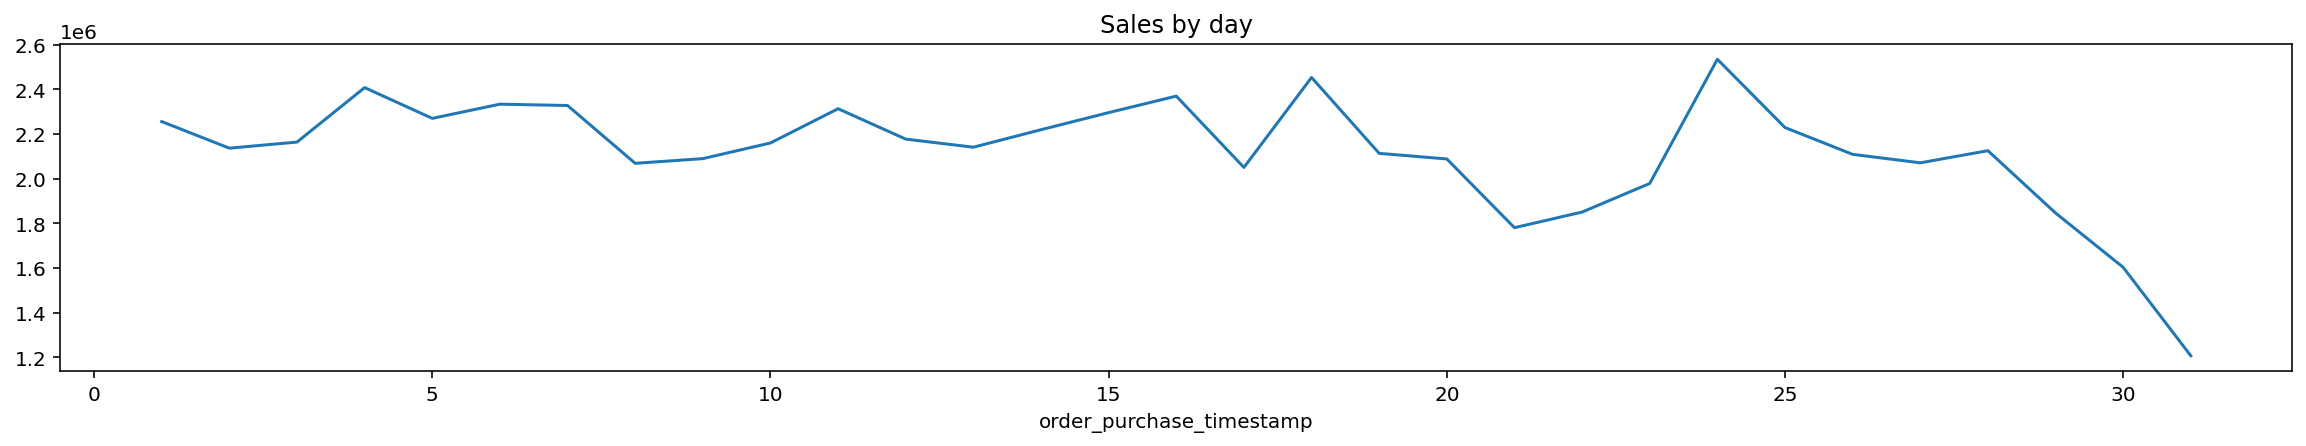

In [ ]:
# group by dimension and plot

orders_merged.groupby(orders_merged['order_purchase_timestamp'].dt.day)['order_value'].sum().plot()
plt.title('Sales by day')

Text(0.5, 1.0, 'Sales by week')

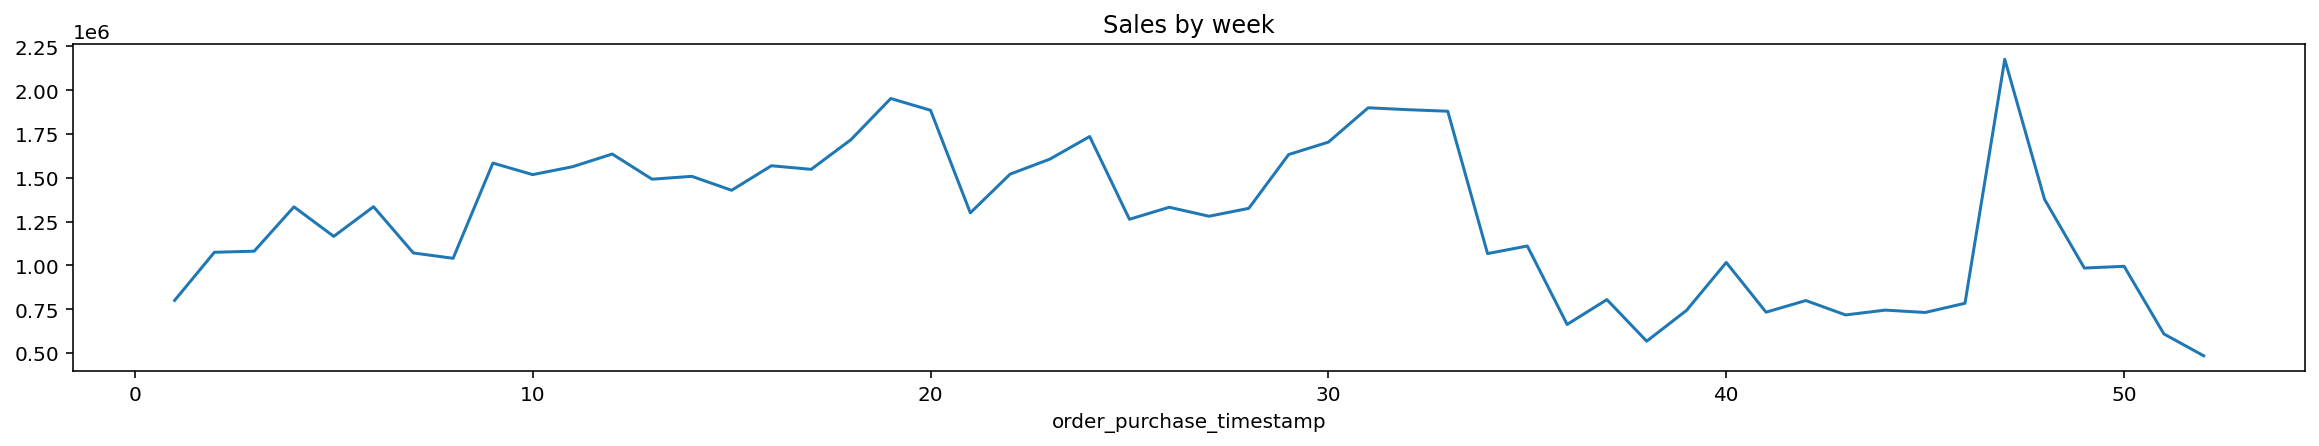

In [ ]:
orders_merged.groupby(orders_merged['order_purchase_timestamp'].dt.week)['order_value'].sum().plot()

plt.title('Sales by week')

Text(0.5, 1.0, 'Sales by month')

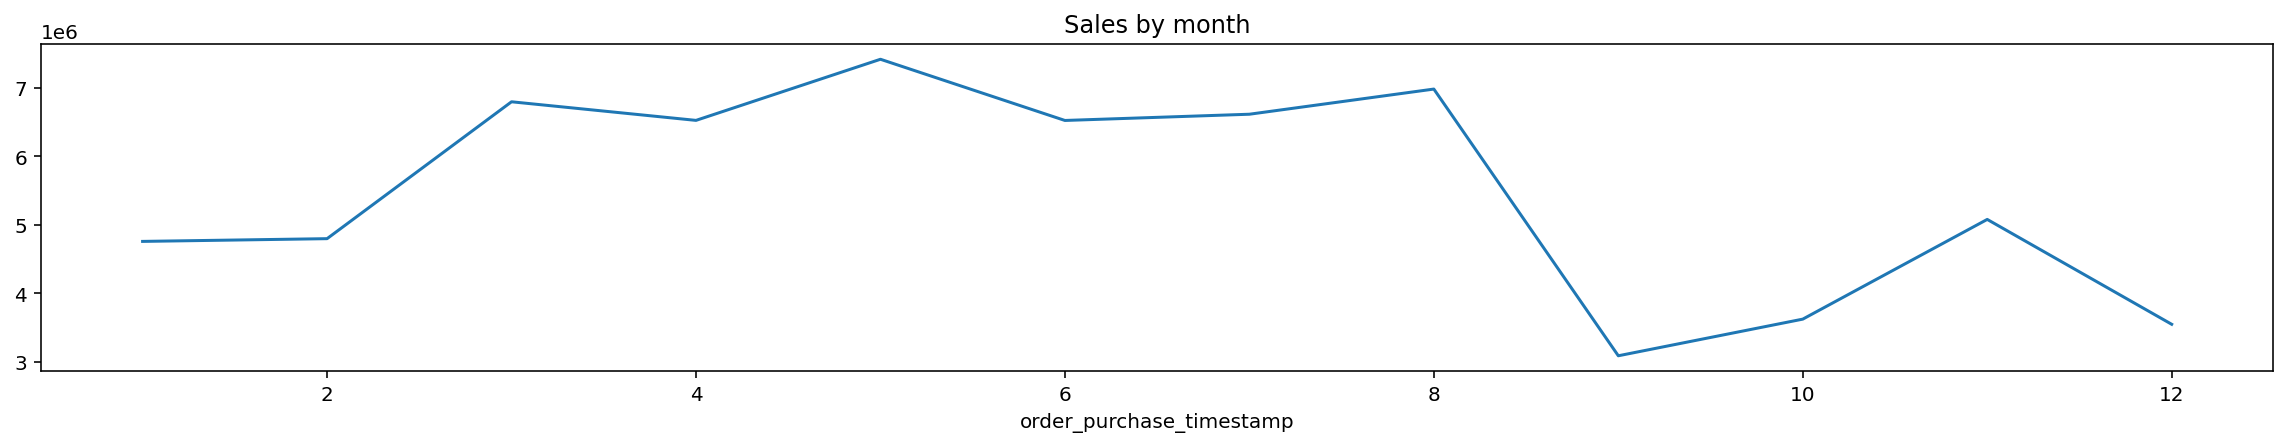

In [ ]:
orders_merged.groupby(orders_merged['order_purchase_timestamp'].dt.month)['order_value'].sum().plot()
plt.title('Sales by month')

### Average value of transaction
This KPI gives insights about how a tipical shopping basked value evolves over time: from this is possible to underastand if customers
tend to buy multiple items in one order or rather have many small transactions. It is helpful when, for example, when architecting some promotions or discounts.

To achieve this we can use a strategy similar to the previous one: we will group transaction value by the month and get the average.

In [ ]:
print('Average value of order by month')
avg_value = orders_merged.groupby(orders_merged['order_purchase_timestamp'].dt.month)['order_value'].mean().reset_index()
avg_value.columns = ['Month', 'Value']

avg_value = avg_value.round(2)
avg_value['Month'] = pd.to_datetime(avg_value['Month'], format='%m').dt.month_name().str.slice(stop=3)

avg_value

Average value of order by month


,Month,Value
0,Jan,565.73
1,Feb,543.04
2,Mar,656.70
3,Apr,667.17
4,May,669.42
5,Jun,661.97
6,Jul,611.11
7,Aug,620.71
8,Sep,681.56
9,Oct,696.39


Deepnote offers a really cool feature that lets you automatically plot data from a dataframe, just press on the "visualize" table inside the output section of a cell:

In [ ]:
avg_value

,Month,Value
0,Jan,565.73
1,Feb,543.04
2,Mar,656.70
3,Apr,667.17
4,May,669.42
5,Jun,661.97
6,Jul,611.11
7,Aug,620.71
8,Sep,681.56
9,Oct,696.39


### Where customers are based
Knowing the location where customer are based open the gates for many things: it is possible to understand which areas are more profitable than other, 
where out customers are based, and which regions/cities tend to spend more (or less) money on our platform.

In order to get the data ready we can, again, have a look at the schema: the `olist_customers_dataset` 
table contains informations customers geography. We can use this table and do some `groupby` along with `value_counts:`

In [ ]:
customers = pd.read_csv('e-commerce-data/olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customers['customer_city'].value_counts().to_frame()

,customer_city
sao paulo,15540
rio de janeiro,6882
belo horizonte,2773
brasilia,2131
curitiba,1521
...,...
sao clemente,1
lencois,1
simplicio mendes,1
pedras altas,1


In [ ]:
orders = pd.read_csv('e-commerce-data/olist_orders_dataset.csv')
orders.info()

print('\n')

order_items = pd.read_csv('e-commerce-data/olist_order_items_dataset.csv')
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  objec

### Most popular ordered products
To get this view it is necessary to merge the `olist_orders_dataset` with the `olist_order_items_dataset`, 
the two tables can be joined using the `order_id` column. 
Then, similarly as before, it can be possible to count values of the `product_id` column. 
However, to get the item category, another join operation is needed: the item category name is stored inside the `olist_products_dataset`, 
which can be joined with `olist_order_items_dataset` using the `product_id` column.

In [ ]:
orders_merged_items = orders.merge(order_items, how='inner', on='order_id')[['product_id']]
orders_merged_items.head()

,product_id
0,87285b34884572647811a353c7ac498a
1,595fac2a385ac33a80bd5114aec74eb8
2,aa4383b373c6aca5d8797843e5594415
3,d0b61bfb1de832b15ba9d266ca96e5b0
4,65266b2da20d04dbe00c5c2d3bb7859e


In [ ]:
product_desc = pd.read_csv('e-commerce-data/olist_products_dataset.csv')
product_desc.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
# join orders_merged_items with product_desc on product_id column
product_count = orders_merged_items.merge(product_desc, how='inner', on='product_id')
product_count.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,87285b34884572647811a353c7ac498a,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,595fac2a385ac33a80bd5114aec74eb8,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0


Everything seems to work well, however, product category names are in Portuguese, and not in english. 
Luckily the dataset comes with another table `product_category_name_translation` which, for every category name, the translated name in english. We can substitute the portuguses column with the english one:

In [ ]:
eng_cat = pd.read_csv('e-commerce-data/product_category_name_translation.csv')
eng_cat.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
product_count = product_count.merge(eng_cat)

It is not possible to apply the `value_counts` function and plot the 20 most common categories:

<AxesSubplot:>

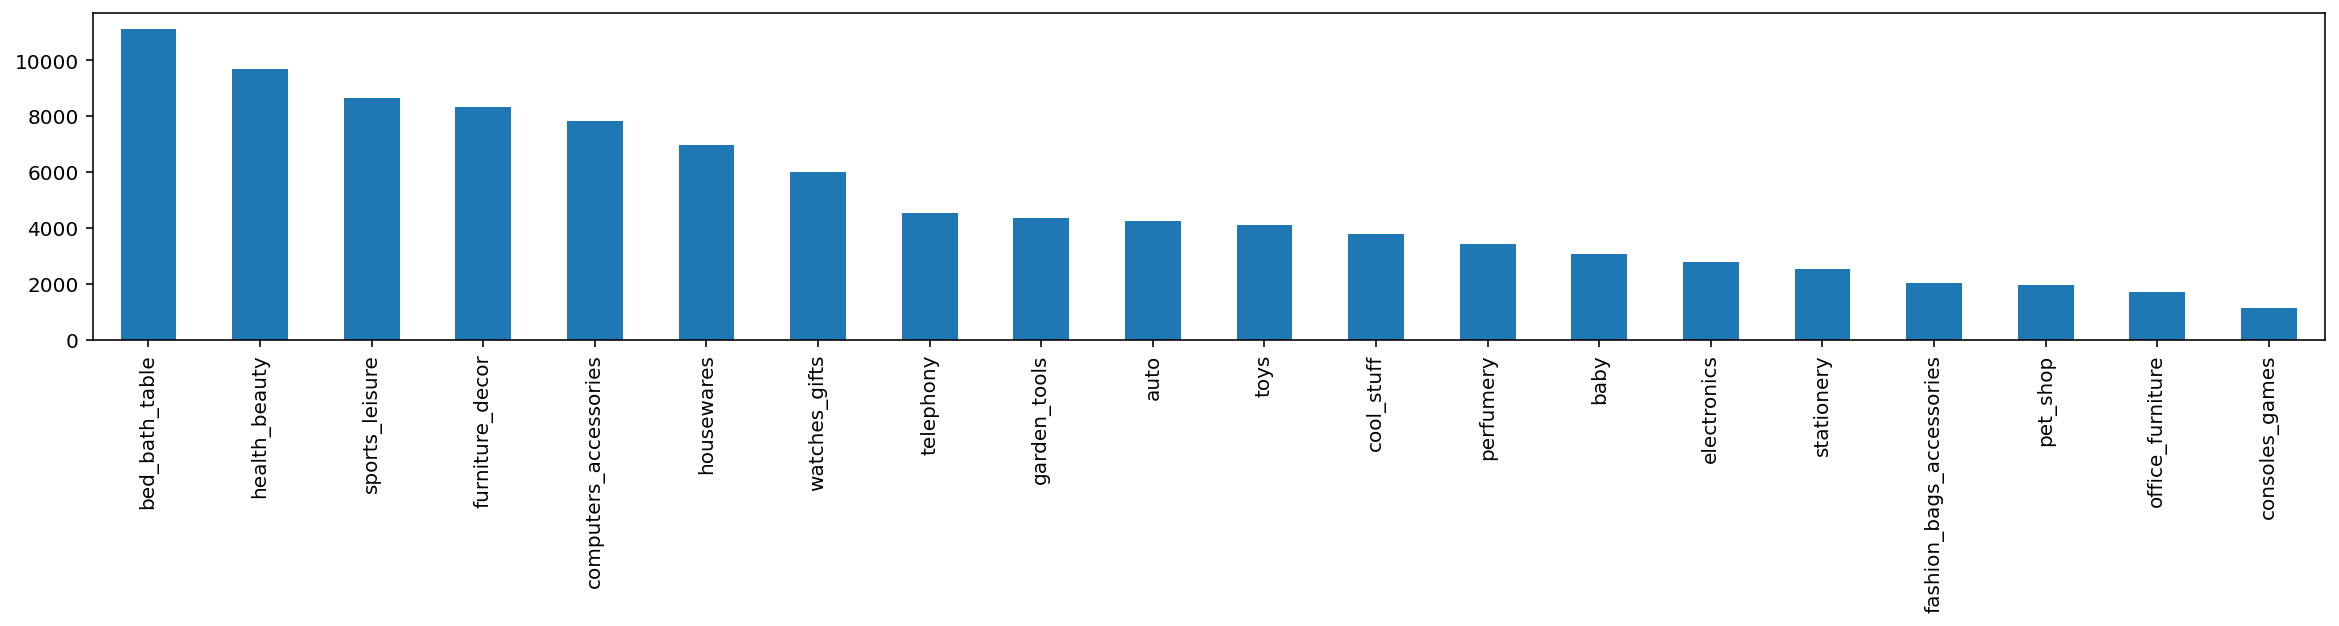

In [ ]:
product_count['product_category_name_english'].value_counts()[0:20].plot(kind='bar')

## Where to go now?
In this short guide I wanted to show some basic operation that could help you switching from the old-fashioned spreadsheet to
notebooks. Additional examples, tips and guides can be found in the [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html#intro-to-pandas)
docuementation. 

Regarding this dataset in particualar, I want to give you some starting points where you could expand this tutorial, for example, 
you could use the the `olist_geolocation_dataset` along with the joined `olist_customers_dataset` and ` olist_orders_dataset` to create some heatmaps using [`gmaps`](https://jupyter-gmaps.readthedocs.io/en/v0.3.2/gmaps.html)
displaying, for example, where the highest number of orders comes from, or where the average basket value is higher.

Moreover, another good idea could be to create some sort of clustering model for customers, using variables such as the city a customer
comes from, the number of orders, the category of products the customers buys, and many more. Have a look at [this](https://levelup.gitconnected.com/unsupervised-learning-how-to-categorize-an-unlabelled-dataset-480fa2fdddd9) story to get ad idea.

Feel free to copy this notebook, run it, or change it!
[<img src='https://deepnote.com/buttons/launch-in-deepnote.svg'/>](https://deepnote.com/launch?template=deepnote&url=https%3A%2F%2Fgithub.com%2Frobertosannazzaro%2Fditch-spreadsheets-for-notebooks)